# Experiments results 

- Experiment 1: MACHO (PT) - Ogle (FT)
- Experiment 2: MACHO (PT) - Subsets of Ogle (FT) (20 - 50 - 100 observations per class)

In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # comment to disable GPU
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from core.plots import plot_cm

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

def load_weights(model, weights_path):
    model.load_weights(weights_path)
    model.trainable=False
    return model

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Experiment 1: Pretraning on MACHO - Finetuning on Ogle

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from presentation.experiments.exp_1_old import get_mlp, get_lstm, get_lstm_att, init_astromer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from core.data import load_records_v3

In [6]:
astromer_weights = './weights/astromer_10022021/finetuning/alcock'
exp_folder = './experiments/exp_1/alcock/'
data_exp = './data/records/alcock/'

In [7]:
test_obj_df = pd.read_csv(data_exp+'test_objs.csv')

classes_name = list(test_obj_df['class'].unique())
print(classes_name)
num_classes = len(classes_name)

['Cep_0', 'Cep_1', 'EC', 'LPV', 'RRab', 'RRc']


In [8]:
test_batches = load_records_v3(data_exp+'/val', batch_size=128, 
                            max_obs=200,
                            repeat=1,
                            is_train=False,
                            num_cls=num_classes) # repeat 1 == no repeat

Testing mode


In [9]:
from core.encoder import Encoder, EncoderLayer
from core.attention import MultiHeadAttention

In [22]:
encoder = init_astromer(astromer_weights)

In [23]:
def load_model(model, path_weights=''):
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
    load_status = model.load_weights(path_weights)
    return model

In [24]:
lstm     = get_lstm(256, num_classes, 200, dropout=0.5)
lstm     = load_model(lstm, exp_folder+"/lstm_att/ckpt")
lstm_att = get_lstm_att(256, num_classes, encoder=encoder, dropout=0.5)
lstm_att = load_model(lstm_att, exp_folder+"/lstm_att/ckpt")
mlp_att  = get_mlp(num_classes, encoder)
mlp_att  = load_model(mlp_att, exp_folder+"/mlp_att/ckpt")

In [25]:
y_pred_lstm = np.argmax(lstm.predict(test_batches), 1)
y_pred_lstm_att = np.argmax(lstm_att.predict(test_batches), 1)
y_pred_mlp_att = np.argmax(mlp_att.predict(test_batches), 1)

In [26]:
y_true = np.concatenate([tf.argmax(y, 1) for x, y in test_batches], 0)

In [27]:
%%time
lstm_results     = {'name': 'LSTM', 'y_pred': [], 'y_true': [], 'cce': 0., 'acc':0.}
mlp_att_results  = {'name': 'MLP+ATT', 'y_pred': [], 'y_true': [], 'cce': 0., 'acc':0.}
lstm_att_results = {'name': 'LSTM+ATT', 'y_pred': [], 'y_true': [], 'cce': 0., 'acc':0.}


lstm_results['y_pred'] = y_pred_lstm
lstm_results['y_true'] = y_true
lstm_results['cce'], lstm_results['acc'] = lstm.evaluate(test_batches)

lstm_att_results['y_pred'] = y_pred_lstm_att
lstm_att_results['y_true'] = y_true
lstm_att_results['cce'], lstm_att_results['acc'] = lstm_att.evaluate(test_batches)

mlp_att_results['y_pred'] = y_pred_mlp_att
mlp_att_results['y_true'] = y_true
mlp_att_results['cce'], mlp_att_results['acc'] = mlp_att.evaluate(test_batches)

32/32 [==============================] - 16s 460ms/step - loss: 1.8595 - accuracy: 0.4473
CPU times: user 4min 33s, sys: 20.6 s, total: 4min 54s
Wall time: 53.1 s


In [28]:
# from sklearn.metrics import accuracy_score

print(mlp_att_results['acc'], lstm_att_results['acc'], lstm_results['acc'])

0.4473229646682739 0.613372802734375 0.053787317126989365


In [29]:
# lstm_s = [0.09, 0.10, 0.09, 0.11]
# mlp_s = [0.48, 0.56, 0.55, 0.66]
# lstm_att_s = [0.58, 0.63, 0.62, 0.75]

In [30]:
# plt.figure(figsize=(5,3), dpi=300)
# x_range = [20, 50, 100, 500]
# plt.plot(x_range, lstm_s, marker='o', label='LSTM')
# plt.plot(x_range, mlp_s, marker='o', label='MLP+ATT')
# plt.plot(x_range, lstm_att_s, marker='o', label='LSTM+ATT')
# plt.ylabel('Macro F1 Score')
# plt.xlabel('Samples per class')
# plt.xticks(x_range)
# plt.legend()
# plt.show()

In [31]:
print('{} & {} & {} & {} \\\\\hline'.format('Model', 'F1 Score', 'Recall', 'Precision'))
for result in [lstm_results, mlp_att_results, lstm_att_results]:        
    prec, recall, f1, _ = precision_recall_fscore_support(result['y_true'], 
                                                          result['y_pred'], 
                                                          average='macro')
    
    print('{} & {:.2f} & {:.2f} & {:.2f} \\\\\hline'.format(result['name'], f1, recall, prec))

Model & F1 Score & Recall & Precision \\\hline
LSTM & 0.02 & 0.17 & 0.26 \\\hline
MLP+ATT & 0.25 & 0.26 & 0.28 \\\hline
LSTM+ATT & 0.37 & 0.40 & 0.35 \\\hline


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}


Text(0.0, 0.5, 'Categorical Cross Entropy')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


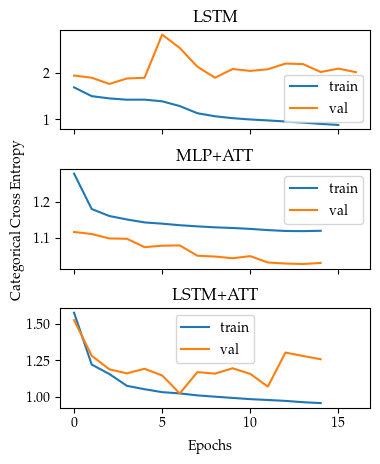

In [10]:
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics_2(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['scalars']}
    print(metrics)
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'batch_2': continue
            value = v.simple_value
            metrics[v.tag].append(value)
    
    
    metrics['xentropy'] = metrics.pop('epoch_loss')
    metrics['accuracy'] = metrics.pop('epoch_accuracy')
    
    return metrics

fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=100, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):


    val_metrics = get_metrics_2(os.path.join(
        exp_folder, name, 'logs', 'validation'))
    train_metrics = get_metrics_2(
        os.path.join(exp_folder, name, 'logs', 'train'))

        
    axes[index].plot(train_metrics['xentropy'], label='train')
    axes[index].plot(val_metrics['xentropy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Categorical Cross Entropy', va='center', rotation='vertical')

{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}
{'epoch_loss': [], 'epoch_accuracy': []}


Text(0.0, 0.5, 'Accuracy')

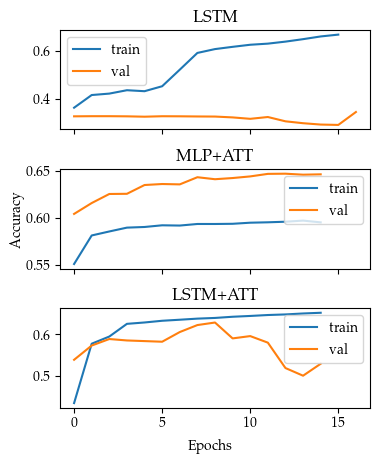

In [11]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=100, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
    val_metrics = get_metrics_2(os.path.join(
        exp_folder, name, 'logs', 'validation'))
    train_metrics = get_metrics_2(
        os.path.join(exp_folder, name, 'logs', 'train'))

        
    axes[index].plot(train_metrics['accuracy'], label='train')
    axes[index].plot(val_metrics['accuracy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Accuracy', va='center', rotation='vertical')

In [116]:
lstm_cm     = confusion_matrix(lstm_results['y_true'], lstm_results['y_pred'], normalize='true')
lstm_att_cm = confusion_matrix(lstm_att_results['y_true'], lstm_att_results['y_pred'], normalize='true')
mlp_att_cm  = confusion_matrix(mlp_att_results['y_true'], mlp_att_results['y_pred'], normalize='true')

In [117]:
classes_name = [x.replace('_', '\_') for x in classes_name]

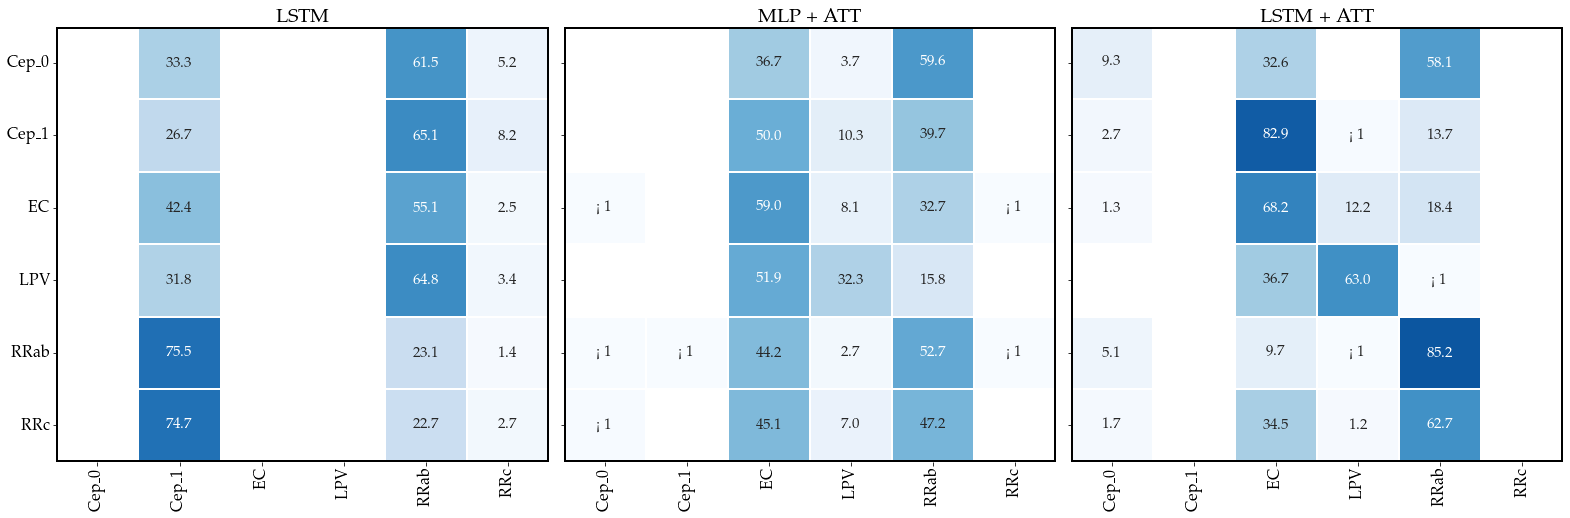

In [118]:
fig, axes = plt.subplots(1,3, figsize=(27,8), sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.03})

axes[0] = plot_cm(lstm_cm, axes[0], title='LSTM', class_names=classes_name)
axes[1] = plot_cm(mlp_att_cm, axes[1], title='MLP + ATT', class_names=classes_name)
axes[2] = plot_cm(lstm_att_cm, axes[2], title='LSTM + ATT', class_names=classes_name)